# Preprocess TIMIT dataset

## Download dataset to machine

In [1]:
import os

CURRENT_DIR = ""

# If statements save time on rerunning this cell
if not os.path.exists('darpa-timit-acousticphonetic-continuous-speech.zip'):
  !kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech

import zipfile
if not os.listdir('data/'): 
    with zipfile.ZipFile('darpa-timit-acousticphonetic-continuous-speech.zip', 'r') as zip_ref:
        zip_ref.extractall('data/')
    !rm -f darpa-timit-acousticphonetic-continuous-speech.zip

Dataset URL: https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech
License(s): copyright-authors
 99%|███████████████████████████████████████▍| 818M/829M [00:17<00:00, 66.4MB/s]
100%|████████████████████████████████████████| 829M/829M [00:17<00:00, 49.1MB/s]


In [2]:
# !pip install evaluate accelerate soundfile librosa jiwer tokenizers editdistance -q

## Load dataset in HF Dataset format

In [3]:
import os
import evaluate
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

os.environ["WANDB_DISABLED"] = "true"

raw_datasets = load_dataset("timit_asr", data_dir='data/timit-dataset-kaggle', trust_remote_code=True)

In [4]:
# Look at a sample
# print(raw_datasets['train']['phonetic_detail'][:5])

def create_labels(example):
    # Extracting 'start' from 'phonetic_information' and creating 'phoneme_start'
    example['labels'] = { 'phoneme_start_idx': 
                            example['phonetic_detail']['start'],
                          'utterance': example['phonetic_detail']['utterance']
                        }
    return example

raw_datasets['train'] = raw_datasets['train'].map(create_labels)
raw_datasets['test'] = raw_datasets['test'].map(create_labels)

## Basic data analysis

#### Phoneme Normalization
TODO: Is this actually throwing away using information? We may really care about this phonemes that we're normalizing away.

In [5]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
"""
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}

def convert_phon61_to_phon39(phoneme):
    return phon61_map39[phoneme]

def normalize_phones(sample):
    sample['labels']['utterance'] = [convert_phon61_to_phon39(utterance) for utterance in sample['labels']['utterance']]
    return sample

train_dataset_normalized = raw_datasets['train'].map(normalize_phones)
test_dataset_normalized = raw_datasets['test'].map(normalize_phones)
""";

#### Count & chart phoneme distribution

In [6]:
def get_phoneme_list_from_dataset(dataset):
    return [
        phoneme
        for x in dataset['labels']
        for index, phoneme in zip(
            x['phoneme_start_idx'],
            x['utterance'])
    ]

phoneme_list = get_phoneme_list_from_dataset(raw_datasets['train'])
print("num of train phones:\t", len(set(phoneme_list)))
print("list of train phones:\t", set(phoneme_list))

num of train phones:	 61
list of train phones:	 {'dcl', 'n', 'h#', 'pcl', 'hh', 'ix', 'dx', 'l', 'ow', 'uh', 'y', 'axr', 'ay', 'jh', 'ng', 'eh', 'pau', 'bcl', 'el', 's', 'k', 'ax', 'th', 'ux', 'en', 'r', 'ah', 'w', 'g', 'ih', 'ey', 'hv', 'ch', 'epi', 'dh', 'kcl', 'tcl', 'd', 'q', 'm', 'ae', 'iy', 'oy', 't', 'z', 'aa', 'eng', 'b', 'er', 'v', 'nx', 'ao', 'f', 'uw', 'gcl', 'em', 'zh', 'aw', 'ax-h', 'sh', 'p'}


In [7]:
# Normalize phonemes

def get_phoneme_list_from_dataset(dataset):
    return [
        phoneme
        for x in dataset['labels']
        for index, phoneme in zip(
            x['phoneme_start_idx'],
            x['utterance'])
    ]

phoneme_list = get_phoneme_list_from_dataset(raw_datasets['train'])
print(
    "num of train phones after normalization:\t",
    len(set(phoneme_list))
)
print("list of train phones after normalization:\t", set(phoneme_list))


num of train phones after normalization:	 61
list of train phones after normalization:	 {'dcl', 'n', 'h#', 'pcl', 'hh', 'ix', 'dx', 'l', 'ow', 'uh', 'y', 'axr', 'ay', 'jh', 'ng', 'eh', 'pau', 'bcl', 'el', 's', 'k', 'ax', 'th', 'ux', 'en', 'r', 'ah', 'w', 'g', 'ih', 'ey', 'hv', 'ch', 'epi', 'dh', 'kcl', 'tcl', 'd', 'q', 'm', 'ae', 'iy', 'oy', 't', 'z', 'aa', 'eng', 'b', 'er', 'v', 'nx', 'ao', 'f', 'uw', 'gcl', 'em', 'zh', 'aw', 'ax-h', 'sh', 'p'}


In [8]:
train_all_phonemes = get_phoneme_list_from_dataset(raw_datasets['train'])
test_all_phonemes = get_phoneme_list_from_dataset(raw_datasets['test'])

phone_vocabs = set(train_all_phonemes)
phone_vocabs.remove('h#')
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    # eliminate h# for visualization purposes
    return [phone_counts[phone] for phone in phone_vocabs] 

In [9]:
train_phoneme_counts = count_frequency(train_all_phonemes)
test_phoneme_counts  = count_frequency(test_all_phonemes)

train_phoneme_ratio = [count / sum(train_phoneme_counts) for count in train_phoneme_counts]
test_phoneme_ratio  = [count / sum(test_phoneme_counts) for count in test_phoneme_counts]

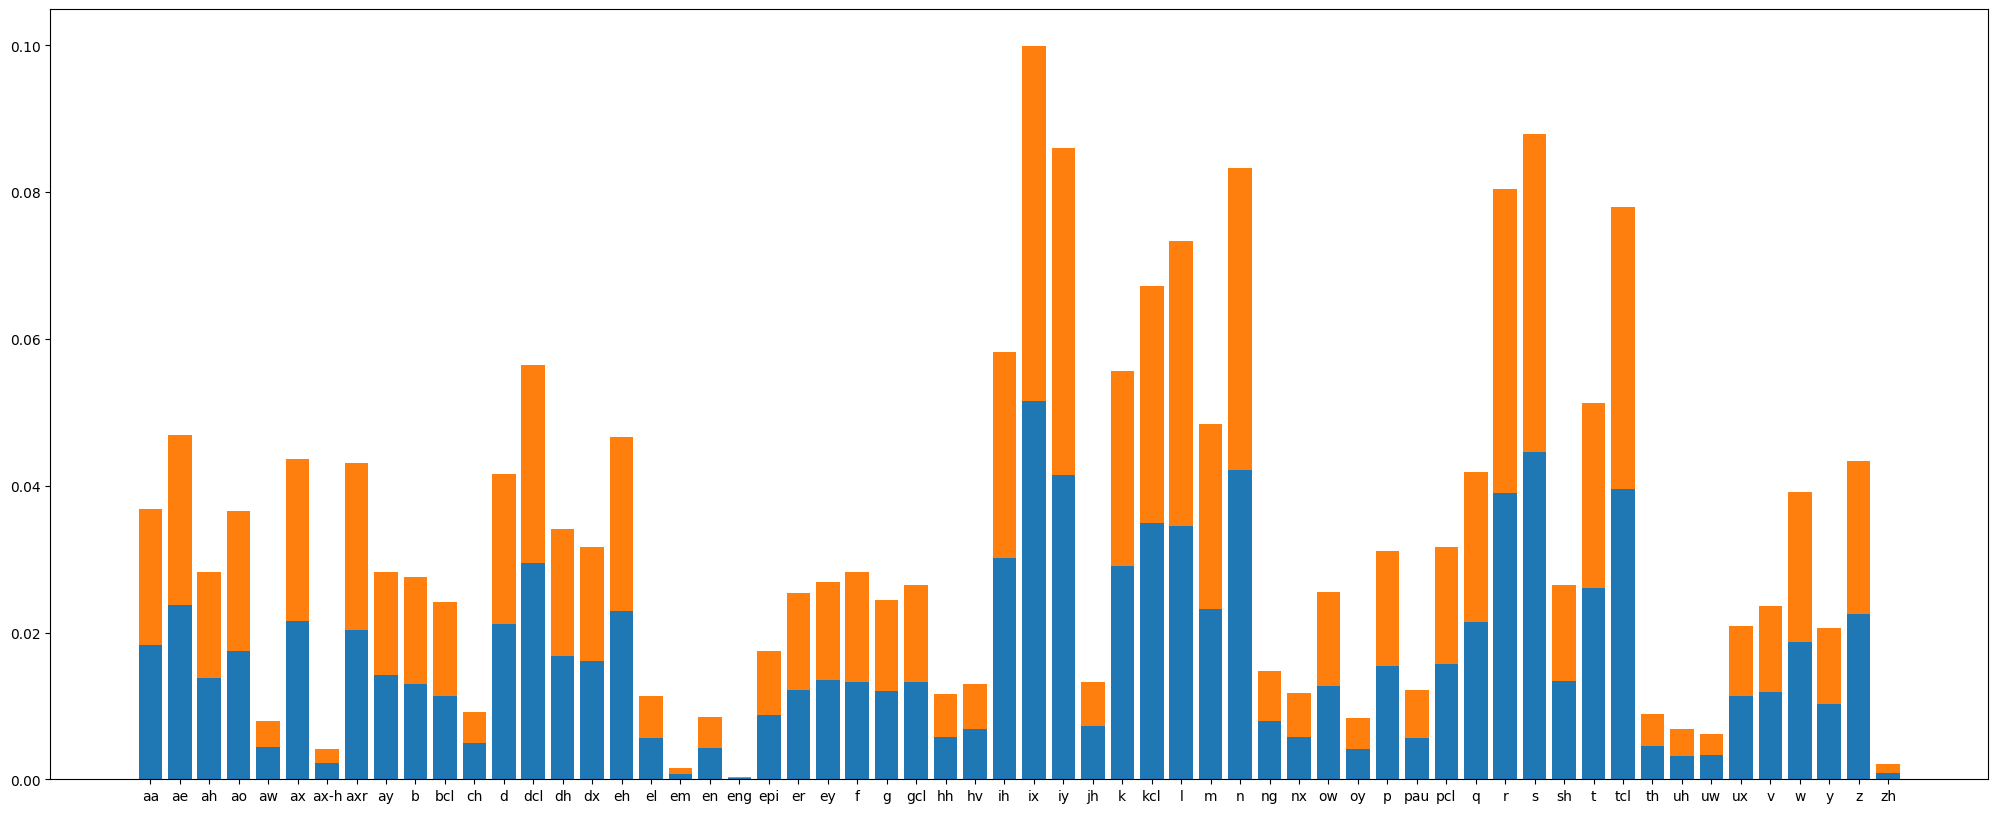

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

plt.bar(phone_vocabs, train_phoneme_ratio)
plt.bar(phone_vocabs, test_phoneme_ratio, bottom=train_phoneme_ratio)
# plt.bar(phone_vocabs, valid_phoneme_ratio, bottom=[(x+y) for x,y in zip(train_phoneme_ratio, test_phoneme_ratio)])

plt.show()

#### Show sample

In [11]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(raw_datasets['train'])-1)

print("Text:", raw_datasets['train'][rand_int]["text"])
print("Labels:", raw_datasets['train'][rand_int]["labels"])
print("Input array shape:", raw_datasets['train'][rand_int]["audio"]["array"].shape)
print("Sampling rate:", raw_datasets['train'][rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=raw_datasets['train'][rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: Critical equipment needs proper maintenance.
Labels: {'phoneme_start_idx': [0, 2260, 2920, 3266, 3960, 4280, 5000, 5950, 6880, 7895, 8647, 9600, 10390, 10940, 11633, 12368, 12960, 13781, 15190, 16626, 17364, 17562, 18101, 18922, 19589, 20135, 21597, 22500, 23030, 23628, 24800, 26400, 26987, 27530, 28600, 28866, 29618, 30351, 31415, 32080, 32364, 33810], 'utterance': ['h#', 'k', 'r', 'ih', 'dx', 'ih', 'kcl', 'k', 'el', 'ax', 'kcl', 'k', 'w', 'ih', 'q', 'm', 'ix', 'n', 'iy', 'dcl', 'd', 'z', 'pcl', 'p', 'r', 'aa', 'pcl', 'p', 'axr', 'm', 'ey', 'n', 'tcl', 't', 'ix', 'n', 'ix', 'n', 'tcl', 't', 's', 'h#']}
Input array shape: (36250,)
Sampling rate: 16000


## Build Model Vocabulary
TODO: Probably don't need a vocab because we won't even be using a tokenizer?

In [12]:
"""
### Create general vocab_dict
vocab_train = list(set(get_phoneme_list_from_dataset(raw_datasets['train']))) + [' ']
# vocab_valid = list(set(get_phoneme_list_from_dataset(raw_datasets['valid'])) + [' ']
vocab_valid = []
vocab_test  = list(set(get_phoneme_list_from_dataset(raw_datasets['test']))) + [' ']

all_unique_phonemes = list(set(vocab_train + vocab_test + vocab_valid))
vocab_dict = {v: k for k, v in enumerate(sorted(all_unique_phonemes))}

print(len(vocab_dict), vocab_dict)

### Add control tokens 
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))

### Save vocab to file
import json
with open('./vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)
""";

# Modeling

## Define utility classes

### Data Collator

In [13]:
import torch
from dataclasses import dataclass, field
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorForAudioWithPadding:
    """
    Data collator that dynamically pads both the inputs and labels received.
    This is specialized for audio processing tasks where labels include phoneme information and frame indices.

    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`):
            The processor used for processing the audio data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, optional, defaults to `True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index).
    """
    processor: Any  # Adjusted to generic 'Any' if not specifically using Wav2Vec2Processor
    padding: Union[bool, str] = True
    
    def __init__(self, processor, padding=True, tokenizer=None):
        self.processor = processor
        self.padding = padding
        self.tokenizer = tokenizer  # Added tokenizer

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # Separate audio input values from labels since they need different padding methods
        input_features = [{"input_values": feature["audio"]} for feature in features]
        labels = [{"labels": feature["labels"]} for feature in features]

        # Pad audio input features
        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        # Pad labels without any processor since labels are numerical indices (no text tokenization)
        max_label_length = max(len(l["labels"]['phoneme_start_idx']) for l in labels)
        padded_labels = torch.full((len(labels), max_label_length), -100, dtype=torch.long)  # Using -100 as the padding value for labels
        padded_labels_start_idx = torch.full((len(labels), max_label_length), -100, dtype=torch.long)  # Using -100 as the padding value for labels
        padded_labels_utterance = torch.full((len(labels), max_label_length), -100, dtype=torch.long)  # Using -100 as the padding value for labels
        
        # Our labels are structured like:
        # [{
        #   "phoneme_start_idxs": [],
        #   "utterance": []
        # }]
        for i, label in enumerate(labels):
            label_length = len(label["labels"]['phoneme_start_idx'])

            padded_labels_start_idx[i, :label_length] = torch.tensor(label["labels"]['phoneme_start_idx'], dtype=torch.long)
            padded_labels_utterance[i, :label_length] = torch.tensor(tokenizer.convert_tokens_to_ids(label["labels"]['utterance']), dtype=torch.long)
            padded_labels = {'phoneme_start_idx': padded_labels_start_idx, 'utterance': padded_labels_utterance}

        batch["labels"] = padded_labels

        return batch

### Tokenizer

In [14]:
from transformers import PreTrainedTokenizer
    
class PhonemeTokenizer(PreTrainedTokenizer):
    def __init__(self, phoneme_to_id, id_to_phoneme):
        self.phoneme_to_id = phoneme_to_id
        self.id_to_phoneme = id_to_phoneme
        self.pad_token = "<pad>"

    def tokenize(self, phonemes):
        return [self.phoneme_to_id[ph] for ph in phonemes]

    def convert_tokens_to_ids(self, tokens):
        return [self.phoneme_to_id[token] if token in self.phoneme_to_id else self.phoneme_to_id["<unk>"] for token in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self.id_to_phoneme[id.item()] for id in ids if id.item() in self.id_to_phoneme]

    def pad(self, encoded_inputs, max_length=None, padding_strategy="longest"):
        max_len = max_length or max(len(inputs) for inputs in encoded_inputs)
        padded = [inp + [self.phoneme_to_id[self.pad_token]] * (max_len - len(inp)) for inp in encoded_inputs]
        return padded

## Instantiate utility objects

#### Create HF Dataset objects

In [17]:
from datasets import Dataset

BATCH_SIZE = 8

minimal_train_dataset = raw_datasets['train'].select(range(len(raw_datasets['train'])), ['audio', 'labels'])
minimal_test_dataset = raw_datasets['test'].select(range(len(raw_datasets['test'])), ['audio', 'labels'])

debug_train_dataset = minimal_train_dataset.shuffle(seed=42).select(range(2048))
debug_valid_dataset = minimal_test_dataset.shuffle(seed=42).select(range(64))

### Instantiate Tokenizer

In [18]:
# Calc unique phonemes
unique_phonemes = set()
for label in minimal_train_dataset['labels']:
    unique_phonemes.update(label['utterance'])
    
print(len(unique_phonemes))
    
# Create bidirectional dicts
phoneme_to_id = {}
id_to_phoneme = {}
for phoneme_id, phoneme in enumerate(unique_phonemes):
    phoneme_to_id[phoneme] = phoneme_id
    id_to_phoneme[phoneme_id] = phoneme
    
# Create tokenizer    
tokenizer = PhonemeTokenizer(phoneme_to_id, id_to_phoneme)


61


### Instantiate DataCollator

In [19]:
from transformers import PreTrainedTokenizerFast

class MockProcessor:
    def pad(self, features, padding, return_tensors):
        
        max_len = max(len(f["input_values"]['array']) for f in features)
        padded = torch.stack([
            torch.nn.functional.pad(
                torch.tensor(f["input_values"]['array']),
                (0, max_len - len(f["input_values"]['array']))
            ) 
            for f in features])
        return {"input_values": padded}
    

processor = MockProcessor()
collator = DataCollatorForAudioWithPadding(processor=processor, padding=True, tokenizer=tokenizer)

### Instantiate Model & Optimizer

In [77]:
from modeling import Wav2Vec2ForPhonemeAndFramePrediction
from transformers import AdamW

num_phonemes = 61
# model = Wav2Vec2ForPhonemeAndFramePrediction(num_phonemes=61, freeze_feature_encoder=True)
model_xxx = Wav2Vec2ForPhonemeAndFramePrediction(num_phonemes=61, freeze_feature_encoder=True)
optimizer = AdamW(model_xxx.parameters(), lr=2e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=2e-5, momentum=0.9)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_xxx.to(device);

Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([62]) in the model instantiated
- lm_head.weight: found shape torch.Size([32, 768]) in the checkpoint and torch.Size([62, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/dev/jupyter/venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorc

## Prepare for training

#### Clear mem leaks

In [21]:
import gc
import torch

def clear_memory_leaks():
    # Assuming `obj` is the object consuming GPU memory
    obj = None
    gc.collect()
    torch.cuda.empty_cache()
    
clear_memory_leaks()

#### Define helpers

In [22]:
def get_attention_mask_length(attention_mask):
    batch_size, sequence_length = attention_mask.shape
    lengths = torch.zeros(batch_size, dtype=torch.long, device=attention_mask.device)
    
    for i in range(batch_size):
        # Find the index of the last occurrence of 1 in the sequence
        last_one_idx = torch.nonzero(attention_mask[i], as_tuple=True)[0][-1].item()
        
        # Set the length as the position of the last occurrence of 1 plus 1
        lengths[i] = last_one_idx + 1
    
    return lengths

def generate_attention_mask(input_values):
    batch_size, sequence_length = input_values.shape
    attention_mask = torch.zeros((batch_size, sequence_length), dtype=torch.long, device=input_values.device)
    
    for i in range(batch_size):
        last_non_zero_idx = torch.nonzero(input_values[i], as_tuple=True)[0][-1].item()
        attention_mask[i, :last_non_zero_idx + 1] = 1
    
    return attention_mask

## Start training loop

In [71]:
def shape_model_parameters(batch):
    inputs = batch['input_values'].to(device)
    labels = batch['labels']
    frame_labels = labels['phoneme_start_idx'].to(device)
    phoneme_labels = labels['utterance'].to(device)
    attention_mask = generate_attention_mask(batch['input_values']).to(device)

    audio_lengths = attention_mask.sum(-1)
    phoneme_lengths = (phoneme_labels != -100).sum(-1)

    # Move it all to the GPU
    inputs = inputs.to(device).to(torch.float32)
    phoneme_labels = phoneme_labels.to(device).to(torch.float32)
    frame_labels = frame_labels.to(device).to(torch.float32)
    
    return inputs, phoneme_labels, frame_labels, audio_lengths, phoneme_lengths

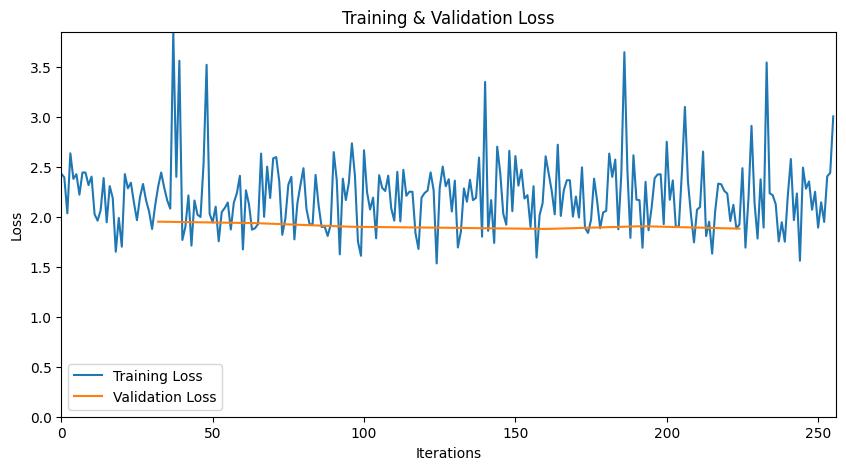

Running validation set against model...
Epoch 0, Training loss: 2.2072518952190876
Epoch 0, Validation loss: 1.8753249794244766


In [75]:
from config import SAMPLE_RATE, WINDOW_SIZE
from modeling import custom_loss_function
from utils import create_bit_mask_of_frame_start_positions, frame_pos_to_nth_window

from torch.utils.data import DataLoader
# from IPython.display import clear_output, display
# import matplotlib.pyplot as plt

# Assume `train_dataset` is an instance of a custom Dataset class handling TIMIT data
# num_epochs = 10
num_epochs = 1
train_losses = []

train_loader = DataLoader(debug_train_dataset, batch_size=BATCH_SIZE, collate_fn=collator) #shuffle=True
valid_loader = DataLoader(debug_valid_dataset, batch_size=BATCH_SIZE, collate_fn=collator) #shuffle=True

steps_taken = 0
progress_bar = tqdm(range(len(train_loader) * num_epochs))

# Create chart
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], label='Training Loss')
val_line, = ax.plot([], [], label='Validation Loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Training & Validation Loss')
ax.legend()

validation_losses = []
validation_iterations = []

for epoch in range(num_epochs):
    train_loss = 0.0  # Add this line to initialize the training loss accumulator
    for batch in train_loader:    
        model.train()
        
        inputs, phoneme_labels, frame_labels, audio_lengths, phoneme_lengths = shape_model_parameters(batch)
        
        # Convert the input tensor to the same data type as the model parameters
        inputs = inputs.to(dtype=next(model.parameters()).dtype)

        phoneme_logits, start_idx_pred, _, _ = model(inputs, phoneme_labels=phoneme_labels, frame_labels=frame_labels, return_log_probs=True)  # Forward pass

        num_windows_in_ea_sample = torch.floor_divide(torch.div(audio_lengths*1000, SAMPLE_RATE) - 5, WINDOW_SIZE).long()

        frame_positions = frame_pos_to_nth_window(frame_labels)
        frame_bitmask_labels = create_bit_mask_of_frame_start_positions(frame_positions, phoneme_logits.shape[1]).to(device)

        loss, _, _ = custom_loss_function(
            phoneme_logits,
            start_idx_pred, 
            phoneme_labels, 
            frame_bitmask_labels,
            num_windows_in_ea_sample,
            phoneme_lengths,
            device=device
        )
        
        train_loss += loss.item()  # Add this line to accumulate the training loss
        train_losses.append(loss.item())
        
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        progress_bar.update(1)
        
        steps_taken += 1
        # break
        
        ## Plot train losses
        line.set_data(range(len(train_losses)), train_losses)
        ax.set_xlim(0, len(train_losses))
        ax.set_ylim(0, max(train_losses)) #max(train_losses)
        
        clear_output(wait=True)
        display(fig)
        
        if steps_taken % 32 == 0:
            model.eval()
            print('Running validation set against model...')
            val_loss = 0.0
            with torch.no_grad():
                for val_batch in valid_loader:
                    inputs, phoneme_labels, frame_labels, audio_lengths, phoneme_lengths = shape_model_parameters(val_batch)

                    # Inference and Loss Computation
                    phoneme_logits, start_idx_pred, log_probs, loss = model(inputs, phoneme_labels=phoneme_labels, frame_labels=frame_labels, return_log_probs=True)

                    # Assuming `custom_loss_function` is defined and `frame_bitmask_labels` and `num_windows_in_ea_sample` are computed
                    frame_positions = frame_pos_to_nth_window(frame_labels)
                    frame_bitmask_labels = create_bit_mask_of_frame_start_positions(frame_positions, phoneme_logits.shape[1]).to(device)
                    num_windows_in_ea_sample = torch.floor_divide(torch.div(audio_lengths*1000, SAMPLE_RATE) - 5, WINDOW_SIZE).long()

                    batch_val_loss, _, _ = custom_loss_function(
                        phoneme_logits,
                        start_idx_pred, 
                        phoneme_labels, 
                        frame_bitmask_labels,
                        num_windows_in_ea_sample,
                        phoneme_lengths,
                        device=device
                    )
                    
                    val_loss += batch_val_loss.item()

            val_loss /= len(valid_loader)
            validation_losses.append(val_loss)
            validation_iterations.append(steps_taken)

            # Plot validation losses
            val_line.set_data(validation_iterations, validation_losses)

    
    train_loss /= len(train_loader)  # Add this line to calculate the average training loss

    
    print(f"Epoch {epoch}, Training loss: {train_loss}")  # Add this line to print the average training loss
    print(f"Epoch {epoch}, Validation loss: {val_loss}")
    
plt.close(fig)

In [27]:
import torch
from datetime import datetime
from pathlib import Path

# Get current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a filename with the datetime prefix
model_filename = f"{current_datetime}_badbeagle_model.pth"

# Create a Path object for the models directory and the full file path
models_dir = Path("models")
model_path = models_dir / model_filename

# Create the models directory if it doesn't exist
models_dir.mkdir(parents=True, exist_ok=True)

# Save the model
torch.save(model.state_dict(), model_path)

print(f"Model saved as: {model_path}")

Model saved as: models/20241009_221308_badbeagle_model.pth


# Measure training performance

In [32]:
num_phonemes = 61
model_untrained = Wav2Vec2ForPhonemeAndFramePrediction(num_phonemes=61, freeze_feature_encoder=True)
model_untrained.to(device);

batch = next(iter(valid_loader))
idx = 6
batch = {
    'input_values': batch['input_values'][idx].unsqueeze(0), 
    'labels': { 
        'phoneme_start_idx': batch['labels']['phoneme_start_idx'][idx].unsqueeze(0), 
        'utterance': batch['labels']['utterance'][idx].unsqueeze(0) 
    }
}


Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([62]) in the model instantiated
- lm_head.weight: found shape torch.Size([32, 768]) in the checkpoint and torch.Size([62, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Run inference on trained + untrained model

In [67]:
from importlib import reload
import config
reload(config)
import utils
reload(utils)

from utils import frame_pos_to_nth_window, create_bit_mask_of_frame_start_positions


#### EXTRACT COMMON DATA FROM BATCH
inputs, phoneme_labels, frame_labels, audio_lengths, phoneme_lengths = shape_model_parameters(batch)

#### CREATE GROUND TRUTH FRAME MARKERS
frame_positions = frame_pos_to_nth_window(frame_labels)
frame_bitmask_labels = create_bit_mask_of_frame_start_positions(frame_positions, phoneme_logits.shape[1]).to(device)
print(f"Frame markers - actual: ", frame_labels[0].shape)

num_windows_in_ea_sample = torch.floor_divide(torch.div(audio_lengths*1000, config.SAMPLE_RATE) - 5, config.WINDOW_SIZE).long()

#### [INFERENCE] TRAINED MODEL
phoneme_logits, start_idx_pred, log_probs, loss = model(inputs, phoneme_labels=phoneme_labels, frame_labels=frame_labels, return_log_probs=True)
print(f"Frame markers - trained: ", start_idx_pred.shape)

loss, phoneme_loss, frame_start_loss = custom_loss_function(
    phoneme_logits, # FROM MODEL
    start_idx_pred, # FROM MODEL
    # -------
    phoneme_labels, # FROM BATCH
    frame_bitmask_labels, # FROM BATCH
    num_windows_in_ea_sample, # FROM BATCH
    phoneme_lengths # FROM BATCH
)

#### [INFERENCE] UNTRAINED MODEL
phoneme_logits_UN, start_idx_pred_UN, log_probs_UN, loss_UN = model_untrained(inputs, phoneme_labels=phoneme_labels, frame_labels=frame_labels, return_log_probs=True)
print(f"Frame markers - untrained: ", start_idx_pred_UN.shape)

loss_UN, phoneme_loss_UN, frame_start_loss_UN = custom_loss_function(
    phoneme_logits_UN, # FROM MODEL
    start_idx_pred_UN,  # FROM MODEL
    # -------
    phoneme_labels, # FROM BATCH
    frame_bitmask_labels, # FROM BATCH
    num_windows_in_ea_sample, # FROM BATCH
    phoneme_lengths # FROM BATCH
)


#### [LOGGING]
print(f"Epoch {epoch}, TRAINED  | Frame Start Validation loss: {frame_start_loss.item()}")
print(f"Epoch {epoch}, UNTRAINED| Frame Start Validation loss: {frame_start_loss_UN.item()}")
print(f"Epoch {epoch}, TRAINED  | Phoneme loss: {phoneme_loss.item()}")
print(f"Epoch {epoch}, UNTRAINED| Phoneme loss: {phoneme_loss_UN.item()}")

Frame markers - actual:  torch.Size([53])
Frame markers - trained:  torch.Size([1, 184])
Frame markers - untrained:  torch.Size([1, 184])
Epoch 7, TRAINED  | Frame Start Validation loss: 0.10856045037508011
Epoch 7, UNTRAINED| Frame Start Validation loss: 0.34865695238113403
Epoch 7, TRAINED  | Phoneme loss: 0.4903548061847687
Epoch 7, UNTRAINED| Phoneme loss: 12.134283065795898


## Actual vs. predicted Frame Marker positions

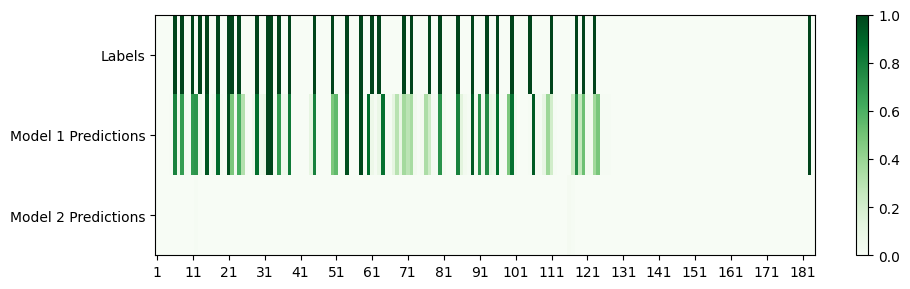

In [38]:
from plots import visualize_bitmask

visualize_bitmask(frame_bitmask_labels.squeeze(0), start_idx_pred.squeeze(0), start_idx_pred_UN.squeeze(0))

## Spectrogram + Framestart marker overlay

torch.Size([1, 184, 62])


(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Spectrogram with Phoneme Markers'}, xlabel='Time (s)', ylabel='Hz'>)

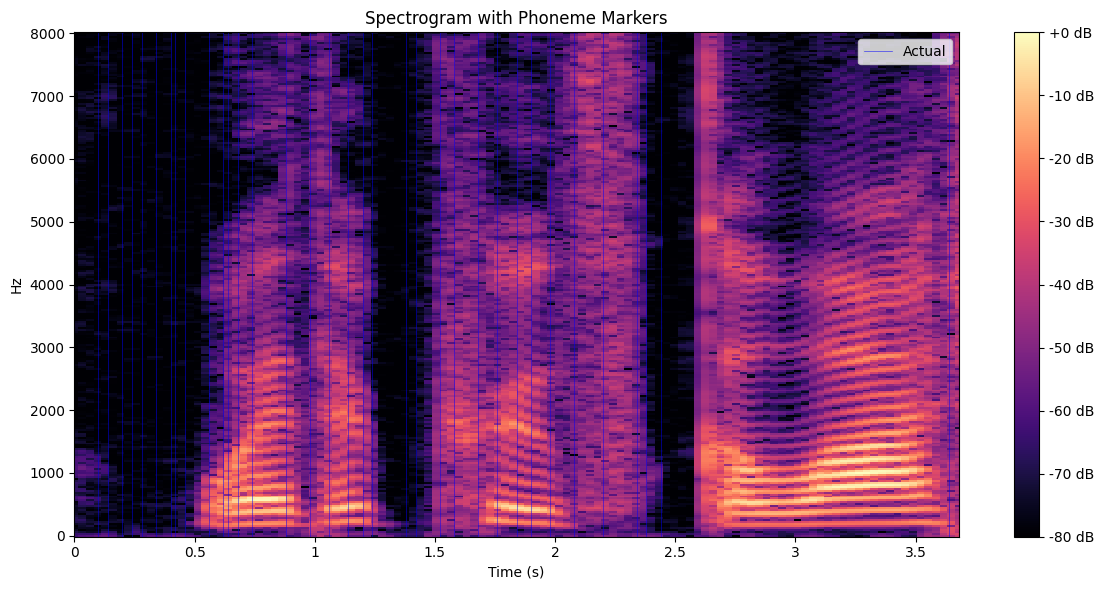

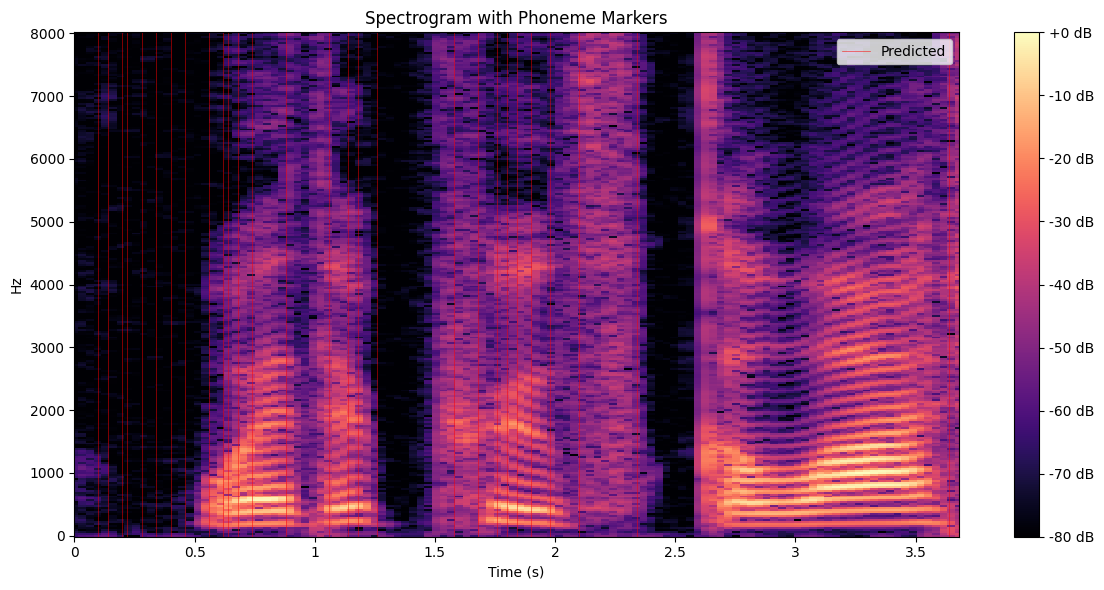

In [36]:
# Variables that must be in scope before this code begins:
# - batch: a dictionary containing 'input_values' and 'labels'
# - start_idx_pred: tensor of predicted start indices
# - frame_pos_to_nth_window: function to convert frame positions to window indices
# - create_bit_mask_of_frame_start_positions: function to create bitmask from start positions
# - device: the device (CPU or GPU) to use for tensor operations

from plots import visualize_audio_and_markers

sample, label = batch['input_values'], batch['labels']

sample_index = 0 
# The window indices
start_window = 0  
end_window = len(start_idx_pred[0]) 

# Get bitmask / start markers
sample_start_idx = label['phoneme_start_idx']
window_start_idx_actual = frame_pos_to_nth_window(sample_start_idx)
start_idx_bitmask_actual = create_bit_mask_of_frame_start_positions(window_start_idx_actual).to(device)

visualize_audio_and_markers(
    sample[sample_index],
    start_window,
    end_window,
    start_idx_bitmask_actual[sample_index],
    label_type='Actual',
    color='blue'
)

visualize_audio_and_markers(
    sample[sample_index],
    start_window,
    end_window,
    start_idx_pred[sample_index] > 0.6,
    label_type='Predicted',
    color='red'
)